# MODIS land surface temperature down-scaling from 1000m resolution to 250m with random forest regression

MODIS land surface temperature (LST) images are available at 1000m resolution. This means that every pixel of the image represents an area of $1 km^2$. While MODIS images are available in varying times of the day, their resolution is not great for the monitoring or study of the urban thermal environment. Landsat images, while providing a better resolution, they are only available once every 16 days and at the same local time of the area of interest. This code uses NDVI images from MODIS, which are provided in $250m$ resolution, as a predictor for the land surface temperature at the same scale effectively generating a new product for land surface temperature. 

MODIS satellite images have been preprocessed and downloaded from https://lpdaacsvc.cr.usgs.gov/appeears/ for the area of interest: Athens, Greece.

The process consists of the following steps:

1. Extracting the LST images
2. Using the filtered LST images to extract the corresponding NDVI images
3. Resampling the NDVI images to 1000m resolution
4. Performing random forest regression for the LST images and the resampled NDVI images
5. Performing residual correction on the predicted images

The land surface temperature is dependent on many physical properties of the surface. Therefore we can use its coverage as the predictor and fit the model to the data of the surface temperature and NDVI (normalised difference vegetation index) , which is a good indicator for potential vegetation on the surface and its intensity.

After the model is trained it can be represented as : $LST_{1000}=f(NDVI_{1000{DEG}})$, where $f$ is a non linear function. In order to correct the simulated images residual correction is performed where the difference (Delta) of the original LST image and the degraded 250m simulated image (the residual) is resampled to 250m and added to the simulated image. 

<br>$\Delta = LST_{1000} - LST_{1000{DEG}}$</br>

$LST_{250_{RES}} = LST_{250} + \Delta_{250}$

<img src = "Athens.jpg" style ="width:900px;height:700px" />



# Land surface temperature extraction   


## At first the needed packages are imported

In [20]:
import numpy as np
import glob
import os
import rasterio
from rasterio.enums import Resampling
import rasterio.mask
import matplotlib.pyplot as plt 
from matplotlib import cm
import shutil
from sklearn.ensemble import RandomForestRegressor

print('Python version ' + sys.version)
print('Numpy version ' + np.__version__)


Python version 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Numpy version 1.21.3


## A simple quality mask is created based on the QA layer

In [21]:
MODIS_flags = {
    'LST_GOOD':0b0000000000000000,
    'OTHER_QA':0b0000000000010001,
    'Clouds':  0b0000000000000010,
    'LST_Err1':0b0000000001000001, 
    'LST_Err2':0b0000000001010001,
    'LST_Err3':0b0000000001100001,
'LST_PRODUCED':0b0000000010010001
  
    }
def get_mask(mask, flags_list):
    
    
    final_mask = np.zeros_like(mask)
    
    
    for flag in flags_list:
       
        flag_mask = np.bitwise_and(mask, MODIS_flags[flag])
        
       
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

## The mask is applied and the resulting image is saved in the folder LST_NIGHT

In [22]:
#Paths to files should be changed accordingly to the users judgement
data_pre_dir_path = 'E:/appearstest/'
modis_LST_Night_list = glob.glob(data_pre_dir_path + '*_LST_Night_1km*.tif')
modis_QC_Night_list = glob.glob(data_pre_dir_path + '*_QC_Night*.tif')

filenames = []
for fname in modis_LST_Night_list :
    filename = os.path.basename(fname)
    filenames.append(filename)


for i in range(len(modis_LST_Night_list)):
    sds_1 = rasterio.open(modis_LST_Night_list[i])
    sds_2 = rasterio.open(modis_QC_Night_list[i])
    sds_1_np = sds_1.read(1, masked = True) * 0.02 
    sds_2_np = sds_2.read(1, masked = True)
  
    sds_2_np = None
    sds_2 = None
    with rasterio.open(
    'E:/appearstest/LST_NIGHT/'+filenames[i],
    'w',
    driver='GTiff',
    height=sds_1.shape[0],
    width=sds_1.shape[1],
    count=1,
    dtype= sds_1_np.dtype,
    crs= sds_1.crs,
    transform= sds_1.transform
    )as dst:
        dst.write(sds_1_np, 1)





## Valid/clear images get separated from the inconclusive  ones based on the number of pixels of value 0. The ratio of "black" pixels over the total of the pixels of the image is calculated to estimate a good threshold for good images. The images of LST_NIGHT are filtered based on the above criteria above and saved in the folder LST_NIGHT_USABLE.


In [23]:

path = 'E:/appearstest/LST_NIGHT/'
LST_NIGHT_list = glob.glob(path + "*.tif")

for i in range(len(modis_LST_Night_list)):
    sds_3 = rasterio.open(modis_LST_Night_list[i])
    sds_3_np = sds_3.read(1)
    number_of_black_pix = np.sum(sds_3_np == 0)
    ratio = number_of_black_pix/(sds_3_np.shape[0]*sds_3_np.shape[1])
    if ratio < 0.3:
        shutil.copy('E:/appearstest/LST_NIGHT/'+filenames[i], 'E:/appearstest/LST_NIGHT_USABLE/')
    

## A crude test to confirm everything works

831
0.25462962962962965


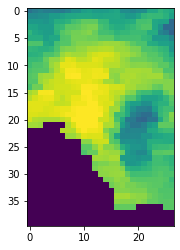

In [24]:
path = 'E:/appearstest/LST_NIGHT_USABLE/'
LST_NIGHT_USABLE_list = glob.glob(path + "*.tif")
print(len(LST_NIGHT_USABLE_list))
LST = rasterio.open(LST_NIGHT_USABLE_list[6])
LST_np = LST.read(1)
number_of_black_pix = np.sum(LST_np == 0)
ratio = number_of_black_pix/(LST_np.shape[0]*LST_np.shape[1])
print(ratio)
plt.imshow(LST_np, vmin = 290, vmax = 299)



# NDVI calculation

## Lists of the corresponding surface reflectance bands (red and near infra red), created based on the naming of the LST_NIGHT_USABLE images. (first NDVI filtering)


In [25]:
data_pre_dir_path = 'E:/appearstest/'
data_dest_path = 'E:/appearstest/NDVI_USABLE'
LST_NIGHT_USABLE = glob.glob(data_pre_dir_path+ "LST_NIGHT_USABLE/" + "*.tif")
band_1_list=[]
band_2_list=[]
modis_QC_list=[]
filename = []

for fname in LST_NIGHT_USABLE :
    m = os.path.basename(fname)
    
    temp, tif = m.split(".tif")
    
    useless , doy = temp.split("_LST_Night_1km")
   
    band_1_list.append("E:/appearstest/MOD09GQ.006_sur_refl_b01_1"+ doy +".tif")
    band_2_list.append("E:/appearstest/MOD09GQ.006_sur_refl_b02_1"+ doy +".tif")
    modis_QC_list.append("E:/appearstest/MOD09GQ.006_QC_250m_1"+ doy +".tif")
    filename.append("E:/appearstest/NDVI/MOD09GQ.006_NDVI_250m"+ doy + ".tif")


 

   

## Calculating the NDVI images and selecting only those that fulfill the criteria enforced by ratio and ratio2 (Second NDVI filtering)

In [26]:
for i in range(len(band_1_list)): 
    RED = rasterio.open(band_1_list[i])
    NIR = rasterio.open(band_2_list[i])
    QC_BAND = rasterio.open(modis_QC_list[i])
   

    ###Reading the bands and applaying the needed no data and quality masks 
    QC_BAND_np = QC_BAND.read(1, masked = True)
    RED_np = RED.read(1, masked = True)
    
    RED_scaled = RED_np *0.0001 
    NIR_np = NIR.read(1 ,masked = True)
    NIR_scaled = NIR_np * 0.0001
    
    np.seterr(divide='ignore', invalid='ignore')
    
    ###Calculating NDVI
    NDVI_np = (NIR_scaled.astype(float) - RED_scaled.astype(float))/(NIR_scaled.astype(float) + RED_scaled.astype(float))
    NDVI_np = np.where(NDVI_np<=0.05,-0.5,NDVI_np)#increasing the contrast by maximising the small values 
    
        
    number_of_light_pix = np.sum(NDVI_np >= 1)
    ratio = number_of_light_pix/(NDVI_np.shape[0]*NDVI_np.shape[1])
    number_of_black_pix = np.sum(NDVI_np <= 0)
    ratio2 = number_of_black_pix/(NDVI_np.shape[0]*NDVI_np.shape[1])

    if ratio <= 0.001 :
        if ratio2 <= 0.25:
            with rasterio.open(
            filename[i],
            'w',
            driver='GTiff',
            height=RED.shape[0],
            width=RED.shape[1],
            count=1,
            dtype= rasterio.float64,
            crs= RED.crs,
            transform= RED.transform
            )as dst:
                dst.write(NDVI_np, 1)
        
                
    


CPLE_AppDefinedError: Deleting E:/appearstest/NDVI/MOD09GQ.006_NDVI_250m_doy2010198_aid0001.tif failed: Permission denied

## Visualising a NDVI image

70
0.0
(158, 108)


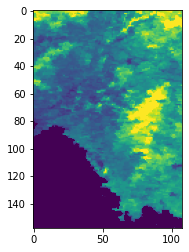

In [ ]:
path = 'E:/appearstest/NDVI/'
NDVI_list = glob.glob(path + "*.tif")
print(len(NDVI_list))
NDVI = rasterio.open(NDVI_list[0])
NDVI_np = NDVI.read(1)
plt.imshow(LST_np, vmin = 0, vmax = 0.5)


## Since we will later use a random forest regression algorithm to make a one-to-one connection between the images , we will filter out all the LST images which do not have a good quality corresponding NDVI image, in order to have the same amount of LST and NDVI images. (LST second filtering)

In the following code block we extract the day of the year of the NDVI image and make a list of all the LST images with the same day of the year in their name, we than copy the files that are in the said list and transfer them to a new folder.

In [ ]:
path_LST= 'E:/appearstest/LST_NIGHT_USABLE/'
LST_NIGHT_USABLE_LIST = glob.glob(path_LST + "*.tif")


path_NDVI= 'E:/appearstest/NDVI/'
NDVI_LIST = glob.glob(path_NDVI + "*.tif")

doy_list = []
for i in range(len(NDVI_LIST)):
    fname1 = os.path.basename(NDVI_LIST[i])
    m1 = os.path.basename(fname1)
    temp1, tif1 = m1.split(".tif")
    useless1 , ndvi_doy = temp1.split("MOD09GQ.006_NDVI_250m")
    doy_list.append('E:/appearstest/LST_NIGHT_USABLE/MOD11A1.006_LST_Night_1km'+ndvi_doy+ ".tif")


for j in range(len(LST_NIGHT_USABLE_LIST)):   
    if LST_NIGHT_USABLE_LIST[j] in doy_list:
        shutil.copy(LST_NIGHT_USABLE_LIST[j], 'E:/appearstest/LST_NIGHT_F/')
    else : 
        pass

## A crude test to check if the files were transfered

In [ ]:
path_LST_F= 'E:/appearstest/LST_NIGHT_F/'
LST_NIGHT_F_list = glob.glob(path_LST_F + "*.tif")
print(len(LST_NIGHT_F_list))

path_NDVI= 'E:/appearstest/NDVI/'
NDVI_LIST = glob.glob(path_NDVI + "*.tif")
print(len(NDVI_LIST))

70
70


# Resampling the NDVI images  
Each pixel's side is 250m and therefore the NDVI images have 16 times more pixels than the LST images of 1000m each side. The images are resampled to a "worse" resolution via mean aggregation in order for the machine learning model to be later trained on images of the same resolution-dimension.

In [ ]:
data_pre_dir_path = 'E:/appearstest/NDVI_USABLE/'
NDVI_USABLE_list = glob.glob(data_pre_dir_path + '*.tif')
a = np.empty((40,27)) 

for i in range(len(NDVI_USABLE_list)):
    filename = os.path.basename(NDVI_USABLE_list[i])
    upscale_factor = 1/4

    with rasterio.open(NDVI_USABLE_list[i]) as dataset:

        
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.average
        )
        data = np.where(data <= 0.05, 0, data )

    
    with rasterio.open(
    'E:/appearstest/NDVI_TRAINING/250'+filename,
    'w',
        driver='GTiff',
        height=a.shape[0],
        width=a.shape[1],
        count=1,
        dtype= data.dtype,
        crs= dataset.crs,
        transform= dataset.transform
        )as dst:
            dst.write(data)

## Fast test to check if the image has been resampled correctly

(40, 27)


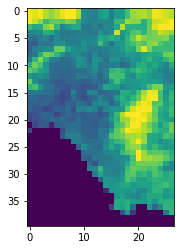

In [ ]:
path = 'E:/appearstest/NDVI_TRAINING/'
testlist = glob.glob(path +'*.tif')
test = rasterio.open(testlist[4])
test_np = test.read(1,masked = True)
print(test_np.shape)
plt.imshow(test_np,vmin = 0,vmax=0.5)
plt.show()

# Random Forest Regression

In [ ]:
predictor_train_set_path = "E:/appearstest/NDVI_TRAINING/"
predictor_train_set_list = glob.glob(predictor_train_set_path + "*.tif")

label_train_set_path = "E:/appearstest/LST_NIGHT_F/"
label_train_set_list = glob.glob(label_train_set_path + "*.tif")

test_set_path = "E:/appearstest/NDVI/"
test_set_list = glob.glob(test_set_path + "*.tif")

filenames = []
for fname in label_train_set_list :
     filename = os.path.basename(fname)
     filenames.append(filename)
print(len(filenames))
print(len(test_set_list))

70
70


## Looping through the images, reading and "clipping" them between values in an effort to improve visualisation later on . 

The .fit method takes vector-like arguments, thus the images need to be transformed from 2d numpy arrays to 1d arrays (vectors) in order to train the model. However, the images used for the training of the model have a resolution of 1000m, while the images used for the predictions have a 250m resolution. When flattened, the vectors of the images are not of the same length and the .predict method will lead to an error. To tackle this problem, the test set images with 16 times more pixels than the training set images, are split into smaller arrays. Theses arrays, when flattened, have the same length as the vectors of the training set images. We then perform the prediction and reassemble the previously split arrays into the full predicted image.

In [ ]:
for i in range(len(label_train_set_list)):
 
    label_train_set = rasterio.open(label_train_set_list[i])
    label_train_set_np = label_train_set.read(1,masked = False)
    label_train_set_np = np.clip(label_train_set_np, 280,label_train_set_np.max())
    label_train_set_np = label_train_set_np.reshape(-1, 1).flatten()
    

    predictor_train_set = rasterio.open(predictor_train_set_list[i])
    predictor_train_set_np = predictor_train_set.read(1,masked = False)
    predictor_train_set_np = np.clip(predictor_train_set_np,-0.5,0.5)
    predictor_train_set_np = predictor_train_set_np.reshape(-1, 1)
   
    
    test_set = rasterio.open(test_set_list[i])
    test_set_np = test_set.read(1, masked = False)
    empty = np.full((2,108), 0,float)
    test_set_np = np.append(test_set_np,empty,axis = 0) 
    split = np.array_split(test_set_np, 4, axis = 0) 
    
    new_l = []
    for j in range(len(split)):
        split_2 = np.array_split(split[j], 4 , axis = 1)
        new_l += split_2
        

    x_train = predictor_train_set_np
    y_train = label_train_set_np
    

    regressor = RandomForestRegressor(n_estimators=100,random_state=0)
    regressor.fit(x_train, y_train)
    final = []
    
    for k in range(len(new_l)):
        temp = new_l[k].reshape(-1, 1)
        y_pred = regressor.predict(temp)
        y_pred = y_pred.reshape(40,27)
        final.append(y_pred)

    
    r1 = np.concatenate((final[0],final[1],final[2],final[3]), axis = 1)
    r2 = np.concatenate((final[4],final[5],final[6],final[7]),axis = 1)
    r3 = np.concatenate((final[8],final[9],final[10],final[11]), axis = 1)
    r4 = np.concatenate((final[12],final[13],final[14],final[15]), axis = 1)
    
    image = np.concatenate((r1,r2,r3,r4), axis = 0)
    
    predictor_train_set_np = None
    test_set_np = None

    with rasterio.open(
        'E:/appearstest/PREDICTIONS/PRED_'+filenames[i],
        'w',
        driver='GTiff',
        height=image.shape[0],
        width=image.shape[1],
        count=1,
        dtype= label_train_set_np.dtype,
        crs= label_train_set.crs,
        transform= label_train_set.transform
        )as dst:
         dst.write(image, 1)
    
label_train_set_np = None 

# Residual Correction


 

In [ ]:
data_pre_dir_path = 'E:/appearstest/PREDICTIONS/'
pred_list = glob.glob(data_pre_dir_path + '*.tif')

original = 'E:/appearstest/LST_NIGHT_F/'
original_list = glob.glob(original + '*.tif')
print(len(pred_list))

a = np.empty((40,27)) 
for i in range(len(pred_list)):
    filename = os.path.basename(pred_list[i])
    lst = rasterio.open(original_list[i])
    lst_np = lst.read(1,masked = True)

    upscale_factor = 1/4

    with rasterio.open(pred_list[i]) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.average
        )
    

    residual = lst_np - data

    with rasterio.open(
    'E:/appearstest/RESIDUAL/RES'+filename,
    'w',
        driver='GTiff',
        height=a.shape[0],
        width=a.shape[1],
        count=1,
        dtype= data.dtype,
        crs= dataset.crs,
        transform= dataset.transform
        )as dst:
            dst.write(residual)

70


In [ ]:
respath = 'E:/appearstest/RESIDUAL/'
res_list = glob.glob(respath + '*.tif')
downscale_factor = 4
b = np.empty((160,108))
print(len(res_list))
data_pre_dir_path = 'E:/appearstest/PREDICTIONS/'
pred_list = glob.glob(data_pre_dir_path + '*.tif')
for i in range(len(pred_list)):
    filename = os.path.basename(pred_list[i])
    pred_temp = rasterio.open(pred_list[i])
    pred_temp_np = pred_temp.read(1, masked = True)
    upscale_factor = 4

    with rasterio.open(res_list[i]) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.average
        )
    

    final = pred_temp_np + data

    with rasterio.open(
    'E:/appearstest/RES_CORRECTED/COR'+filename,
    'w',
        driver='GTiff',
        height=b.shape[0],
        width=b.shape[1],
        count=1,
        dtype= data.dtype,
        crs= dataset.crs,
        transform= dataset.transform
        )as dst:
            dst.write(final)
print(len(pred_list))

70
70


# Result Visualisation

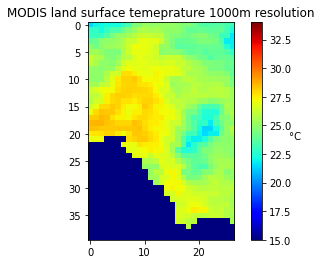

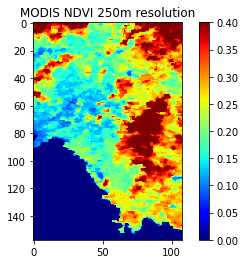

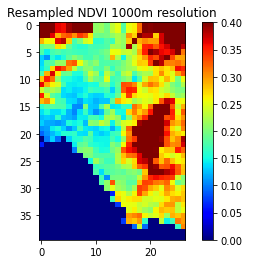

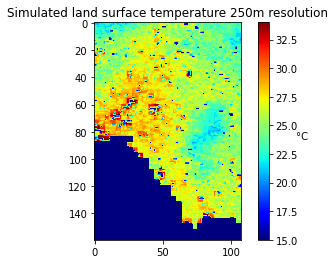

In [ ]:
MODIS_LST = 'E:/appearstest/LST_NIGHT_F/'
MODIS_LST_list = glob.glob(MODIS_LST+"*.tif")

NDVI_path = 'E:/appearstest/NDVI/'
NDVI_list = glob.glob(NDVI_path+"*.tif")

NDVI_TRAINING = 'E:/appearstest/NDVI_TRAINING/'
NDVI_TAINING_list = glob.glob(NDVI_TRAINING+"*.tif")

downscaled = 'E:/appearstest/RES_CORRECTED/'
downscaled_list = glob.glob(downscaled+"*.tif")



LST = rasterio.open(MODIS_LST_list[0])
LST_np = LST.read(1, masked = True) - 273
plt.imshow(LST_np, cmap = cm.jet, vmin = 15,vmax = 34)
plt.colorbar().set_label('°C', rotation=0)
plt.title('MODIS land surface temeprature 1000m resolution')
plt.show()

NDVI = rasterio.open(NDVI_list[0])
NDVI_np = NDVI.read(1, masked = True)
plt.imshow(NDVI_np, cmap = cm.jet, vmin = 0,vmax = 0.4)
plt.colorbar().set_label(' ',rotation=0)
plt.title('MODIS NDVI 250m resolution')
plt.show()

NDVI_upscaled = rasterio.open(NDVI_TAINING_list[0])
NDVI_upscaled_np = NDVI_upscaled.read(1, masked = True)
plt.imshow(NDVI_upscaled_np, cmap = cm.jet, vmin = 0,vmax = 0.4)
plt.colorbar().set_label(' ',rotation=0)
plt.title('Resampled NDVI 1000m resolution')
plt.show()

downscaled = rasterio.open(downscaled_list[0])
downscaled_np = downscaled.read(1, masked = True) - 273
plt.imshow(downscaled_np, cmap = cm.jet, vmin = 15,vmax = 34)
plt.colorbar().set_label('°C', rotation=0)
plt.title('Simulated land surface temperature 250m resolution')
plt.show()